# DCGAN - F-GAN
## f-Divergence GANs
# Note
This Demo is based on './MNIST_VanillaGAN'. The difference with VanillaGAN can be found in ``class divergence``

https://arxiv.org/abs/1606.00709


The authors empirically demonstrate that when the generative model is
misspecified and does not contain the true distribution, the divergence
function used for estimation has a strong influence on which model is
learned. To address this issue, they theoretically show that the
generative-adversarial approach is a special case of an existing, more
general variational divergence estimation approach and that any
f-divergence can be used for training generative neural samplers (which
are defined as models that take a random input vector and produce a sample
from a probability distribution defined by the network weights). They
then empirically show the effect of using different training
divergences on a trained model's average log likelihood of sampled data.

They test (forward) Kullback-Leibler, reverse Kullback-Leibler, Pearson
chi-squared, Neyman chi-squared, squared Hellinger, Jensen-Shannon,
and Jeffrey divergences.

# Import Necessary Packages
有一说一这个DCGAN真的太难训练了啊
我使用的Trick
- ONE-SIDE Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？
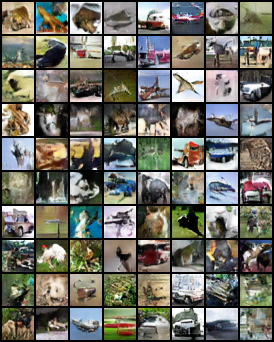


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

import numpy as np

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

- 'total_variation',
- 'forward_kl',
- 'reverse_kl',
- 'pearson',
- 'hellinger',
- 'jensen_shannon'

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 100



ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel

nc = 3 # channels of output images

lr_G = 1e-5
lr_D = 1e-5 # leanring rate of Generator and Discriminator

method = 'pearson'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  7273
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator(Critic) Definitions (Vanilla DCGAN Fashion)
 Critic (not trained to classify). 
 
- 输入一张图片



It is a **unconditional** version.

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

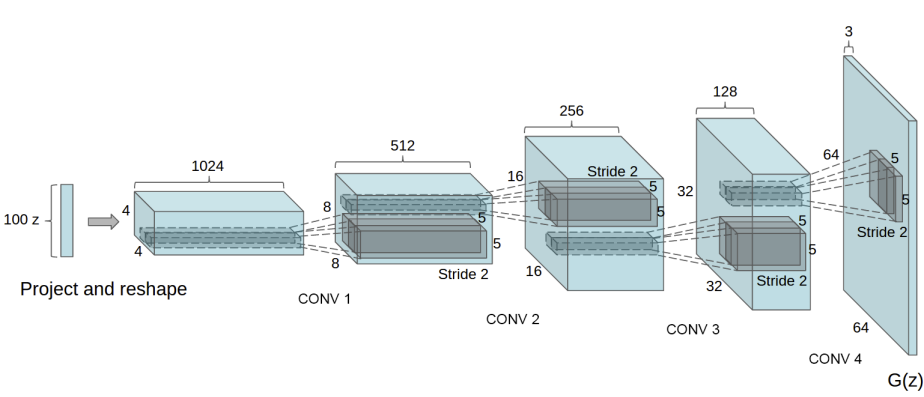

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **unconditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# IMPORTANT: F-Divergence
We exclude Neyman and Jeffrey due to poor performance and nontrivial
implementations to yield 'convergence' (see scipy.special.lambertw
for how to implement Jeffrey, and Table 6 of Appendix C of the paper
for how to implement Neyman)

In [8]:
class Divergence:
    """ Compute G and D loss using an f-divergence metric.
    Implementations based on Table 6 (Appendix C) of the arxiv paper.
    """
    def __init__(self, method):
        self.method = method.lower().strip() # strip() 方法用于移除字符串头尾指定的字符（默认为空格或换行符）或字符序列。
        assert self.method in ['total_variation',
                               'forward_kl',
                               'reverse_kl',
                               'pearson',
                               'hellinger',
                               'jensen_shannon'],\
            'Invalid divergence'
    
    def D_loss(self, DX_score, DG_score):
        """ Compute batch loss for discriminator using f-divergence metric """
        if self.method == 'total_variation':
            return -(torch.mean(0.5 * torch.tanh(DX_score)) \
                - torch.mean(0.5 * torch.tanh(DG_score)))
        
        elif self.method == 'forward_kl':
            return -(torch.mean(DX_score) - torch.mean(torch.exp(DG_score - 1)))
        
        elif self.method == 'reverse_kl':
            return -(torch.mean(-torch.exp(DX_score)) - torch.mean(-1 - DG_score))
        
        elif self.method == 'pearson':
            return -(torch.mean(DX_score) - torch.mean(0.25 * DG_score ** 2 + DG_score))
        
        elif self.method == 'hellinger':
            return -(torch.mean(1 - torch.exp(DX_score)) \
                    - torch.mean((1 - torch.exp(DG_score)) / (torch.exp(DG_score)) ))
        
        elif self.method == 'jensen_shannon':
            return -(torch.mean(torch.tensor(2.) - (1 + torch.exp(-DX_score))) \
                    -torch.mean(-(torch.tensor(2.) - torch.exp(DG_score))))
        
    def G_loss(self, DG_score):
        """ Compute batch loss for generator using f-divergence metric """
        
        if self.method == 'total_variation':
            return -torch.mean(0.5 * torch.tanh(DG_score))
        
        elif self.method == 'forward_kl':
            return -torch.mean(torch.exp(DG_score - 1))
        
        elif self.method == 'reverse_kl':
            return -torch.mean(-1 - DG_score)
        
        elif self.method == 'pearson':
            return -torch.mean(0.25 * DG_score ** 2 + DG_score)
        
        elif self.method == 'hellinger':
            return -torch.mean((1 - torch.exp(DG_score)) / (torch.exp(DG_score)) )
        
        elif self.method == 'jensen_shannon':
            return -torch.mean(-(torch.tensor(2.) - torch.exp(DG_score)))
     
    

# Traning Phase
## Model & Opitmizer

In [9]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)


criterion = Divergence(method)


In [10]:

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.9))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.9))

## Trainning Start!

  0%|          | 0/100 [00:00<?, ?it/s]

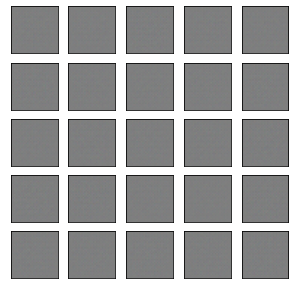

Epoch[0/100],d_loss:0.126595,g_loss:-0.501767 D real: 0.430291,D fake: 0.445465
Epoch[0/100],d_loss:0.050856,g_loss:-0.554783 D real: 0.518300,D fake: 0.488891
Epoch[0/100],d_loss:-0.080783,g_loss:-0.362579 D real: 0.472301,D fake: 0.330707
Epoch[0/100],d_loss:-0.386126,g_loss:-0.156889 D real: 0.567285,D fake: 0.149181


  1%|          | 1/100 [00:14<24:36, 14.91s/it]

Epoch[1/100],d_loss:-0.449517,g_loss:-0.145745 D real: 0.613813,D fake: 0.138407
Epoch[1/100],d_loss:-0.646562,g_loss:-0.106546 D real: 0.764338,D fake: 0.102424
Epoch[1/100],d_loss:-0.706952,g_loss:-0.155401 D real: 0.877043,D fake: 0.147350
Epoch[1/100],d_loss:-0.835371,g_loss:-0.051637 D real: 0.900425,D fake: 0.050527


  2%|▏         | 2/100 [00:27<23:13, 14.22s/it]

Epoch[2/100],d_loss:-0.804932,g_loss:-0.095891 D real: 0.914143,D fake: 0.092243
Epoch[2/100],d_loss:-0.835323,g_loss:-0.056230 D real: 0.908511,D fake: 0.055036
Epoch[2/100],d_loss:-0.923222,g_loss:-0.025730 D real: 0.956928,D fake: 0.025399
Epoch[2/100],d_loss:-0.964602,g_loss:-0.016977 D real: 0.984957,D fake: 0.016816


  3%|▎         | 3/100 [00:39<22:02, 13.63s/it]

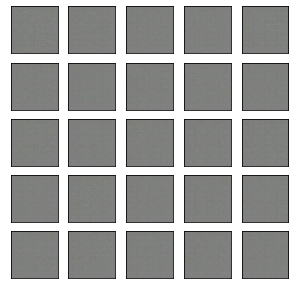

Epoch[3/100],d_loss:-0.925348,g_loss:-0.033596 D real: 0.969990,D fake: 0.033080
Epoch[3/100],d_loss:-0.966424,g_loss:-0.012022 D real: 0.981631,D fake: 0.011933
Epoch[3/100],d_loss:-0.973048,g_loss:-0.011336 D real: 0.985920,D fake: 0.011265
Epoch[3/100],d_loss:-0.970362,g_loss:-0.009740 D real: 0.983850,D fake: 0.009653


  4%|▍         | 4/100 [00:54<22:09, 13.84s/it]

Epoch[4/100],d_loss:-0.980817,g_loss:-0.010234 D real: 0.993478,D fake: 0.010184
Epoch[4/100],d_loss:-0.971725,g_loss:-0.013650 D real: 0.993452,D fake: 0.013559
Epoch[4/100],d_loss:-0.980316,g_loss:-0.008477 D real: 0.989774,D fake: 0.008442
Epoch[4/100],d_loss:-0.953158,g_loss:-0.016727 D real: 0.978284,D fake: 0.016592


  5%|▌         | 5/100 [01:06<21:20, 13.48s/it]

Epoch[5/100],d_loss:-0.867436,g_loss:-0.027836 D real: 0.940199,D fake: 0.027519
Epoch[5/100],d_loss:-0.960338,g_loss:-0.015080 D real: 0.981404,D fake: 0.014921
Epoch[5/100],d_loss:-0.991969,g_loss:-0.003740 D real: 0.996096,D fake: 0.003730
Epoch[5/100],d_loss:-0.997094,g_loss:-0.001325 D real: 0.999199,D fake: 0.001324


  6%|▌         | 6/100 [01:18<20:29, 13.08s/it]

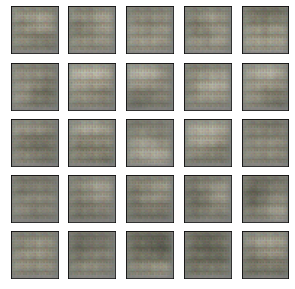

Epoch[6/100],d_loss:-0.996327,g_loss:-0.001519 D real: 0.998878,D fake: 0.001517
Epoch[6/100],d_loss:-0.997557,g_loss:-0.001223 D real: 0.998348,D fake: 0.001222
Epoch[6/100],d_loss:-0.997998,g_loss:-0.000865 D real: 0.998878,D fake: 0.000865
Epoch[6/100],d_loss:-0.998036,g_loss:-0.000565 D real: 0.999159,D fake: 0.000565


  7%|▋         | 7/100 [01:33<20:59, 13.55s/it]

Epoch[7/100],d_loss:-0.997557,g_loss:-0.000743 D real: 0.998165,D fake: 0.000743
Epoch[7/100],d_loss:-0.992056,g_loss:-0.002215 D real: 0.995022,D fake: 0.002212
Epoch[7/100],d_loss:-0.997341,g_loss:-0.000628 D real: 0.998292,D fake: 0.000628
Epoch[7/100],d_loss:-0.998656,g_loss:-0.000702 D real: 0.999336,D fake: 0.000702


  8%|▊         | 8/100 [01:46<20:34, 13.42s/it]

Epoch[8/100],d_loss:-0.999154,g_loss:-0.000355 D real: 0.999612,D fake: 0.000355
Epoch[8/100],d_loss:-0.998852,g_loss:-0.000432 D real: 0.999688,D fake: 0.000432
Epoch[8/100],d_loss:-0.999360,g_loss:-0.000229 D real: 0.999748,D fake: 0.000229
Epoch[8/100],d_loss:-0.998849,g_loss:-0.000446 D real: 0.999364,D fake: 0.000446


  9%|▉         | 9/100 [01:58<19:50, 13.09s/it]

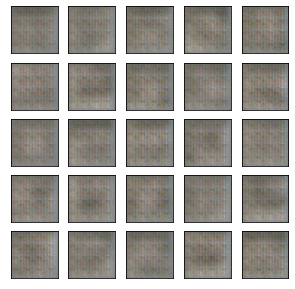

Epoch[9/100],d_loss:-0.999907,g_loss:-0.000029 D real: 0.999951,D fake: 0.000029
Epoch[9/100],d_loss:-0.999541,g_loss:-0.000200 D real: 0.999738,D fake: 0.000200
Epoch[9/100],d_loss:-0.999764,g_loss:-0.000165 D real: 0.999924,D fake: 0.000165
Epoch[9/100],d_loss:-0.998973,g_loss:-0.000706 D real: 0.999608,D fake: 0.000705


 10%|█         | 10/100 [02:12<20:02, 13.36s/it]

Epoch[10/100],d_loss:-0.992054,g_loss:-0.005264 D real: 0.997724,D fake: 0.005234
Epoch[10/100],d_loss:-0.996199,g_loss:-0.000985 D real: 0.997306,D fake: 0.000984
Epoch[10/100],d_loss:-0.996586,g_loss:-0.001073 D real: 0.997421,D fake: 0.001072
Epoch[10/100],d_loss:-0.993493,g_loss:-0.002457 D real: 0.996515,D fake: 0.002451


 11%|█         | 11/100 [02:25<19:24, 13.09s/it]

Epoch[11/100],d_loss:-0.989832,g_loss:-0.005867 D real: 0.997890,D fake: 0.005813
Epoch[11/100],d_loss:-0.889176,g_loss:-0.041348 D real: 0.951511,D fake: 0.040385
Epoch[11/100],d_loss:-0.902835,g_loss:-0.019176 D real: 0.953733,D fake: 0.018837
Epoch[11/100],d_loss:-0.830070,g_loss:-0.043405 D real: 0.942796,D fake: 0.042505


 12%|█▏        | 12/100 [02:37<18:57, 12.93s/it]

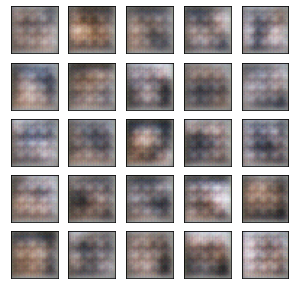

Epoch[12/100],d_loss:-0.851330,g_loss:-0.042420 D real: 0.901413,D fake: 0.041225
Epoch[12/100],d_loss:-0.803297,g_loss:-0.080031 D real: 0.886014,D fake: 0.077208
Epoch[12/100],d_loss:-0.861797,g_loss:-0.066959 D real: 0.913378,D fake: 0.063828
Epoch[12/100],d_loss:-0.866836,g_loss:-0.063342 D real: 0.922830,D fake: 0.061514


 13%|█▎        | 13/100 [02:51<19:00, 13.11s/it]

Epoch[13/100],d_loss:-0.934924,g_loss:-0.019233 D real: 0.961930,D fake: 0.019007
Epoch[13/100],d_loss:-0.941988,g_loss:-0.028463 D real: 0.983605,D fake: 0.027503
Epoch[13/100],d_loss:-0.938522,g_loss:-0.015188 D real: 0.958823,D fake: 0.015044
Epoch[13/100],d_loss:-0.951597,g_loss:-0.019579 D real: 0.973848,D fake: 0.019361


 14%|█▍        | 14/100 [03:04<18:42, 13.06s/it]

Epoch[14/100],d_loss:-0.833982,g_loss:-0.046008 D real: 0.862547,D fake: 0.044916
Epoch[14/100],d_loss:-0.963171,g_loss:-0.014935 D real: 0.976577,D fake: 0.014795
Epoch[14/100],d_loss:-0.896541,g_loss:-0.027630 D real: 0.950872,D fake: 0.027160
Epoch[14/100],d_loss:-0.930663,g_loss:-0.037435 D real: 0.951269,D fake: 0.036624


 15%|█▌        | 15/100 [03:16<18:13, 12.87s/it]

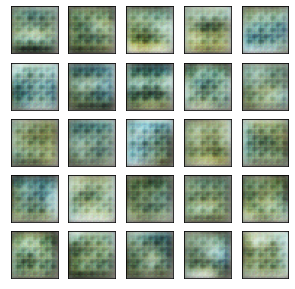

Epoch[15/100],d_loss:-0.945297,g_loss:-0.015195 D real: 0.960423,D fake: 0.015013
Epoch[15/100],d_loss:-0.937938,g_loss:-0.020055 D real: 0.957147,D fake: 0.019810
Epoch[15/100],d_loss:-0.927721,g_loss:-0.032716 D real: 0.958094,D fake: 0.031732
Epoch[15/100],d_loss:-0.939303,g_loss:-0.018889 D real: 0.972476,D fake: 0.018560


 16%|█▌        | 16/100 [03:31<18:34, 13.27s/it]

Epoch[16/100],d_loss:-0.979992,g_loss:-0.008598 D real: 0.988460,D fake: 0.008543
Epoch[16/100],d_loss:-0.973129,g_loss:-0.006598 D real: 0.992758,D fake: 0.006565
Epoch[16/100],d_loss:-0.869403,g_loss:-0.054970 D real: 0.920636,D fake: 0.053437
Epoch[16/100],d_loss:-0.974993,g_loss:-0.015165 D real: 0.995044,D fake: 0.015037


 17%|█▋        | 17/100 [03:44<18:19, 13.24s/it]

Epoch[17/100],d_loss:-0.987013,g_loss:-0.002676 D real: 0.991700,D fake: 0.002670
Epoch[17/100],d_loss:-0.954890,g_loss:-0.014797 D real: 0.971633,D fake: 0.014687
Epoch[17/100],d_loss:-0.943938,g_loss:-0.033173 D real: 0.985140,D fake: 0.032527
Epoch[17/100],d_loss:-0.948430,g_loss:-0.024167 D real: 0.965997,D fake: 0.023879


 18%|█▊        | 18/100 [03:57<17:59, 13.17s/it]

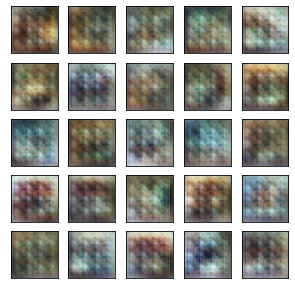

Epoch[18/100],d_loss:-0.913899,g_loss:-0.027939 D real: 0.966148,D fake: 0.027468
Epoch[18/100],d_loss:-0.822679,g_loss:-0.034811 D real: 0.888890,D fake: 0.034025
Epoch[18/100],d_loss:-0.943475,g_loss:-0.037257 D real: 0.982772,D fake: 0.036296
Epoch[18/100],d_loss:-0.913134,g_loss:-0.024985 D real: 0.946068,D fake: 0.024619


 19%|█▉        | 19/100 [04:11<18:08, 13.44s/it]

Epoch[19/100],d_loss:-0.944967,g_loss:-0.032055 D real: 0.972654,D fake: 0.031426
Epoch[19/100],d_loss:-0.926032,g_loss:-0.017351 D real: 0.980064,D fake: 0.017161
Epoch[19/100],d_loss:-0.875841,g_loss:-0.043803 D real: 0.912880,D fake: 0.042821
Epoch[19/100],d_loss:-0.953377,g_loss:-0.030655 D real: 0.981297,D fake: 0.030238


 20%|██        | 20/100 [04:23<17:27, 13.09s/it]

Epoch[20/100],d_loss:-0.960146,g_loss:-0.016292 D real: 0.982138,D fake: 0.016165
Epoch[20/100],d_loss:-0.949830,g_loss:-0.022380 D real: 0.971882,D fake: 0.022115
Epoch[20/100],d_loss:-0.909725,g_loss:-0.041448 D real: 0.954224,D fake: 0.040535
Epoch[20/100],d_loss:-0.917940,g_loss:-0.023359 D real: 0.941579,D fake: 0.022979


 21%|██        | 21/100 [04:36<17:12, 13.07s/it]

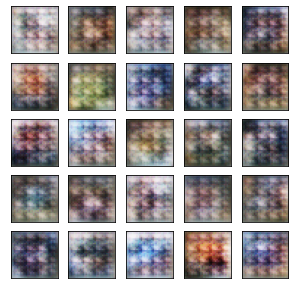

Epoch[21/100],d_loss:-0.964949,g_loss:-0.008505 D real: 0.974613,D fake: 0.008463
Epoch[21/100],d_loss:-0.948922,g_loss:-0.012052 D real: 0.980230,D fake: 0.011956
Epoch[21/100],d_loss:-0.943975,g_loss:-0.020589 D real: 0.970157,D fake: 0.020181
Epoch[21/100],d_loss:-0.969509,g_loss:-0.006856 D real: 0.992276,D fake: 0.006823


 22%|██▏       | 22/100 [04:51<17:50, 13.73s/it]

Epoch[22/100],d_loss:-0.981909,g_loss:-0.005176 D real: 0.991566,D fake: 0.005158
Epoch[22/100],d_loss:-0.956668,g_loss:-0.025599 D real: 0.975068,D fake: 0.025080
Epoch[22/100],d_loss:-0.981887,g_loss:-0.007552 D real: 0.993403,D fake: 0.007486
Epoch[22/100],d_loss:-0.956096,g_loss:-0.013662 D real: 0.973270,D fake: 0.013490


 23%|██▎       | 23/100 [05:05<17:33, 13.68s/it]

Epoch[23/100],d_loss:-0.931578,g_loss:-0.016768 D real: 0.951253,D fake: 0.016631
Epoch[23/100],d_loss:-0.904538,g_loss:-0.048228 D real: 0.963597,D fake: 0.046527
Epoch[23/100],d_loss:-0.975619,g_loss:-0.009012 D real: 0.990770,D fake: 0.008955
Epoch[23/100],d_loss:-0.994484,g_loss:-0.000739 D real: 0.998261,D fake: 0.000738


 24%|██▍       | 24/100 [05:18<16:58, 13.40s/it]

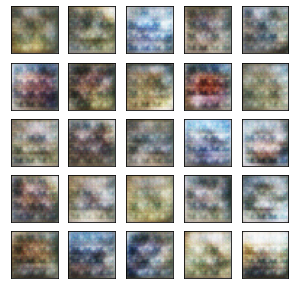

Epoch[24/100],d_loss:-0.903149,g_loss:-0.018456 D real: 0.907917,D fake: 0.018157
Epoch[24/100],d_loss:-0.902219,g_loss:-0.021352 D real: 0.979026,D fake: 0.020996
Epoch[24/100],d_loss:-0.940221,g_loss:-0.047510 D real: 0.973365,D fake: 0.045812
Epoch[24/100],d_loss:-0.991825,g_loss:-0.002306 D real: 0.997527,D fake: 0.002303


 25%|██▌       | 25/100 [05:31<16:41, 13.35s/it]

Epoch[25/100],d_loss:-0.969328,g_loss:-0.011809 D real: 0.986032,D fake: 0.011695
Epoch[25/100],d_loss:-0.988312,g_loss:-0.007906 D real: 0.996464,D fake: 0.007830
Epoch[25/100],d_loss:-0.982755,g_loss:-0.012676 D real: 0.991732,D fake: 0.012570
Epoch[25/100],d_loss:-0.984873,g_loss:-0.008501 D real: 0.991019,D fake: 0.008392


 26%|██▌       | 26/100 [05:43<15:56, 12.93s/it]

Epoch[26/100],d_loss:-0.983880,g_loss:-0.004485 D real: 0.990509,D fake: 0.004471
Epoch[26/100],d_loss:-0.982947,g_loss:-0.003132 D real: 0.994451,D fake: 0.003126
Epoch[26/100],d_loss:-0.998487,g_loss:-0.000191 D real: 0.999447,D fake: 0.000191
Epoch[26/100],d_loss:-0.988087,g_loss:-0.001874 D real: 0.998028,D fake: 0.001871


 27%|██▋       | 27/100 [05:56<15:39, 12.88s/it]

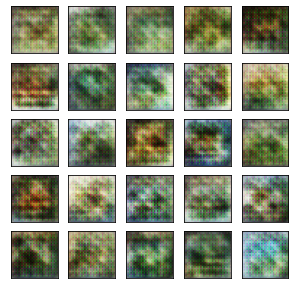

Epoch[27/100],d_loss:-0.998060,g_loss:-0.000455 D real: 0.999105,D fake: 0.000455
Epoch[27/100],d_loss:-0.995660,g_loss:-0.002523 D real: 0.998110,D fake: 0.002514
Epoch[27/100],d_loss:-0.978259,g_loss:-0.008595 D real: 0.980983,D fake: 0.008446
Epoch[27/100],d_loss:-0.985014,g_loss:-0.003745 D real: 0.989883,D fake: 0.003736


 28%|██▊       | 28/100 [06:10<16:00, 13.34s/it]

Epoch[28/100],d_loss:-0.989278,g_loss:-0.003483 D real: 0.992366,D fake: 0.003471
Epoch[28/100],d_loss:-0.992967,g_loss:-0.002876 D real: 0.998322,D fake: 0.002862
Epoch[28/100],d_loss:-0.992661,g_loss:-0.006016 D real: 0.995328,D fake: 0.005986
Epoch[28/100],d_loss:-0.998574,g_loss:-0.000492 D real: 0.999263,D fake: 0.000492


 29%|██▉       | 29/100 [06:23<15:37, 13.21s/it]

Epoch[29/100],d_loss:-0.975166,g_loss:-0.011616 D real: 0.991278,D fake: 0.011381
Epoch[29/100],d_loss:-0.999333,g_loss:-0.000447 D real: 0.999716,D fake: 0.000447
Epoch[29/100],d_loss:-0.999994,g_loss:-0.000004 D real: 0.999997,D fake: 0.000004
Epoch[29/100],d_loss:-0.987069,g_loss:-0.002657 D real: 0.996893,D fake: 0.002652


 30%|███       | 30/100 [06:36<15:18, 13.12s/it]

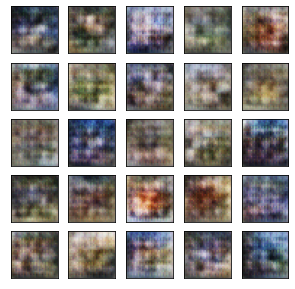

Epoch[30/100],d_loss:-0.986324,g_loss:-0.003744 D real: 0.993662,D fake: 0.003735
Epoch[30/100],d_loss:-0.980958,g_loss:-0.005049 D real: 0.985698,D fake: 0.005019
Epoch[30/100],d_loss:-0.990460,g_loss:-0.007118 D real: 0.997555,D fake: 0.007080
Epoch[30/100],d_loss:-0.993965,g_loss:-0.001321 D real: 0.997907,D fake: 0.001319


 31%|███       | 31/100 [06:50<15:32, 13.51s/it]

Epoch[31/100],d_loss:-0.992748,g_loss:-0.003493 D real: 0.994932,D fake: 0.003474
Epoch[31/100],d_loss:-0.995791,g_loss:-0.002459 D real: 0.996968,D fake: 0.002453
Epoch[31/100],d_loss:-0.998259,g_loss:-0.000654 D real: 0.999173,D fake: 0.000653
Epoch[31/100],d_loss:-0.979553,g_loss:-0.002988 D real: 0.999161,D fake: 0.002974


 32%|███▏      | 32/100 [07:04<15:13, 13.43s/it]

Epoch[32/100],d_loss:-0.995893,g_loss:-0.003263 D real: 0.998800,D fake: 0.003252
Epoch[32/100],d_loss:-0.995464,g_loss:-0.001486 D real: 0.999339,D fake: 0.001484
Epoch[32/100],d_loss:-0.991956,g_loss:-0.001661 D real: 0.998364,D fake: 0.001650
Epoch[32/100],d_loss:-0.990225,g_loss:-0.004857 D real: 0.993626,D fake: 0.004809


 32%|███▏      | 32/100 [07:14<15:23, 13.58s/it]


KeyboardInterrupt: 

In [11]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epoch)):
    if epoch % 3 == 0:
        G.eval()
        z = torch.randn(25, z_dim,1,1).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow((inv_normalize(img[k]) * 255).data.cpu().numpy().transpose((1,2,0)).astype(np.uint8))
            k += 1
        plt.show()
        
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        real_img = img.to(device) # the sampled data are real images


        # ========================= D: Forward and Loss ==========================
        # D_loss: wasserstein loss for discriminator,
        # -E[D(x)] + E[D(G(z))] + λE[(||∇ D(εx + (1 − εG(z)))|| - 1)^2]
        real_out = D(real_img).view(-1,1)
        
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        
        
        d_loss = criterion.D_loss(real_out, fake_out)
        
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        D_losses.append(d_loss)

        # =============== G ========================
        #G_loss: wasserstein loss for generator, -E[D(G(z))]
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)

        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        g_loss = criterion.G_loss(fake_out)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss)
        # ============= Visualization ===============
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean(), #打印的是真实图片的损失均值
            ))
        
'''    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))'''

# Visualization

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Debug 专区

In [ ]:
.expand(real_img.size())